Notes:
- doesn't work even without transit
- try changing priors

Found bug! Independent variable = time for all submodels!!!

In [1]:
from chromatic_fitting import *
from chromatic import Rainbow, SimulatedRainbow
from pymc3 import Normal, Uniform, Model, HalfNormal,Deterministic,  plot_trace, sample_prior_predictive, sample_posterior_predictive
from tqdm import tqdm
from pymc3_ext import eval_in_model, optimize, sample, ParameterGroup
from exoplanet import QuadLimbDark, ImpactParameter
plt.matplotlib.style.use('default')

Running on Python v3.9.12 | packaged by conda-forge | (main, Mar 24 2022, 23:23:20) 
[Clang 12.0.1 ]
Running on numpy v1.22.3
Running on chromatic v0.2.2


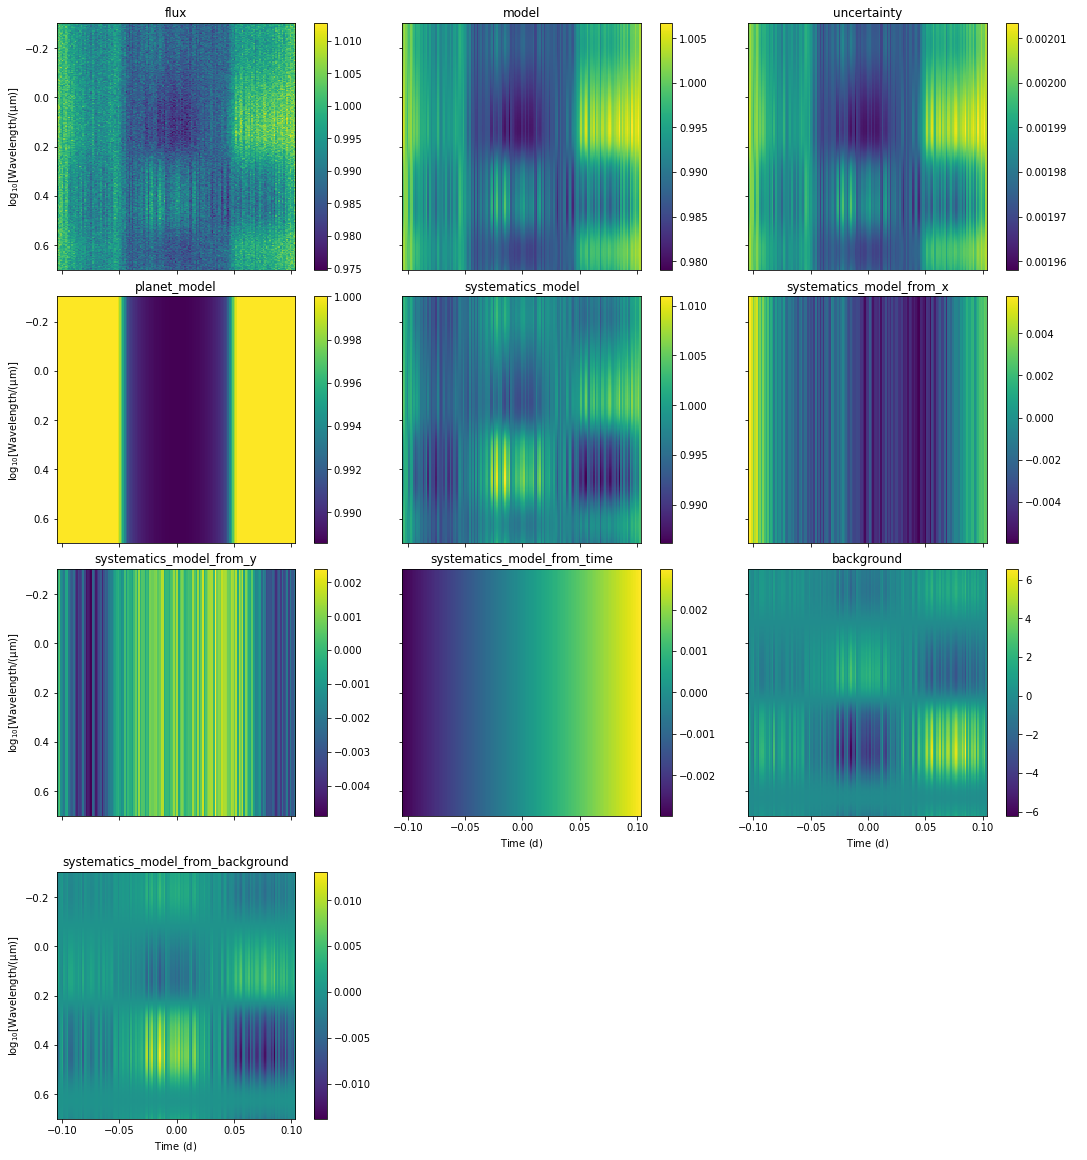

In [22]:
s = SimulatedRainbow().inject_transit().inject_systematics(amplitude=0.002).inject_noise(signal_to_noise=500) #inject_transit().
s.imshow_quantities();
s = s.bin(nwavelengths=int(s.nwave/5), dt=5 * u.minute)

In [44]:
# set up transit model:
t = TransitModel()
t.initialize_empty_model()

t.setup_parameters(
#      period=Fitted(Uniform,testval=4.055259,lower=0.000009),
                  period=1,
                   epoch=Fitted(Uniform,lower=-0.05,upper=0.05),
                   stellar_radius = Fitted(Uniform, lower=0.8, upper=1.2,testval=1),
                   stellar_mass =Fitted(Uniform, lower=0.8, upper=1.2,testval=1),
                   radius_ratio=WavelikeFitted(Normal, mu=0.1, sigma=0.05),
                   impact_parameter=Fitted(ImpactParameter,ror=0.15,testval=0.44),
                   limb_darkening=Fitted(QuadLimbDark,testval=[0.05,0.35]),
                    baseline = 1.0 #Fitted(Uniform, lower=0.95,upper=1.05)
                )

# set up time polynomial model:
b = PolynomialModel(degree=1, name='stime')
b.initialize_empty_model()
b.setup_parameters(
    p_0 = 1.0,
    p_1 = Fitted(Normal,mu=0.0,sigma=0.01),
)

# set up x polynomial model:
b_x = PolynomialModel(degree=1, independant_variable="x", name='sx')
b_x.initialize_empty_model()
b_x.setup_parameters(
    p_1 = Fitted(Normal,mu=0.0,sigma=0.01),
)

# set up y polynomial model:
b_y = PolynomialModel(degree=1, independant_variable="y", name='sy')
b_y.initialize_empty_model()
b_y.setup_parameters(
    p_1 = Fitted(Normal,mu=0.0,sigma=0.01),
)

# set up bkg polynomial model:
b_bkg = PolynomialModel(degree=1, independant_variable="background", name='sbkg')
b_bkg.initialize_empty_model()
b_bkg.setup_parameters(
    p_1 = Fitted(Normal,mu=0.0,sigma=0.01),
)

In [45]:
b_x.parameters

{'sx_p_0': <🧮 Fixed | 0.0 🧮>,
 'sx_p_1': <🧮 Fitted Normal(mu=0.0, sigma=0.01, name='p_1') 🧮>}

In [46]:
b.parameters

{'stime_p_0': <🧮 Fixed | 1.0 🧮>,
 'stime_p_1': <🧮 Fitted Normal(mu=0.0, sigma=0.01, name='p_1') 🧮>}

In [47]:
cm = t * (b + b_x + b_y + b_bkg)

In [48]:
cm

<chromatic combined model 🌈, models: stime(<chromatic polynomial model 🌈>) + sx(<chromatic polynomial model 🌈>) + sy(<chromatic polynomial model 🌈>) + sbkg(<chromatic polynomial model 🌈>) * transit(<chromatic transit model 🌈>)

In [49]:
cm.chromatic_models

{'stime': <chromatic polynomial model 🌈>,
 'sx': <chromatic polynomial model 🌈>,
 'sy': <chromatic polynomial model 🌈>,
 'sbkg': <chromatic polynomial model 🌈>,
 'transit': <chromatic transit model 🌈>}

In [50]:
cm.how_to_combine

['+', '+', '+', '*']

In [51]:
cm.summarize_parameters()

A CombinedModel itself does not have any parameters, however each of its constituent models do:

stime_p_0 =
  <🧮 Fixed | 1.0 🧮>

stime_p_1 =
  <🧮 Fitted Normal(mu=0.0, sigma=0.01, name='stime_p_1') 🧮>

sx_p_0 =
  <🧮 Fixed | 0.0 🧮>

sx_p_1 =
  <🧮 Fitted Normal(mu=0.0, sigma=0.01, name='sx_p_1') 🧮>

sy_p_0 =
  <🧮 Fixed | 0.0 🧮>

sy_p_1 =
  <🧮 Fitted Normal(mu=0.0, sigma=0.01, name='sy_p_1') 🧮>

sbkg_p_0 =
  <🧮 Fixed | 0.0 🧮>

sbkg_p_1 =
  <🧮 Fitted Normal(mu=0.0, sigma=0.01, name='sbkg_p_1') 🧮>

transit_stellar_radius =
  <🧮 Fitted Uniform(lower=0.8, upper=1.2, testval=1, name='transit_stellar_radius') 🧮>

transit_stellar_mass =
  <🧮 Fitted Uniform(lower=0.8, upper=1.2, testval=1, name='transit_stellar_mass') 🧮>

transit_radius_ratio =
  <🧮 WavelikeFitted Normal(mu=0.1, sigma=0.05, name='transit_radius_ratio') for each wavelength 🧮>

transit_period =
  <🧮 Fixed | 1 🧮>

transit_epoch =
  <🧮 Fitted Uniform(lower=-0.05, upper=0.05, name='transit_epoch') 🧮>

transit_baseline =
  <🧮 Fixed | 

In [52]:
cm.attach_data(s)
cm.setup_lightcurves()
cm.setup_likelihood()

100%|██████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 55043.36it/s]


In [53]:
print(cm.chromatic_models)
print()
print(cm.pymc3_model)

{'stime': <chromatic polynomial model 🌈>, 'sx': <chromatic polynomial model 🌈>, 'sy': <chromatic polynomial model 🌈>, 'sbkg': <chromatic polynomial model 🌈>, 'transit': <chromatic transit model 🌈>}

                            stime_p_1 ~ Normal
                               sx_p_1 ~ Normal
                               sy_p_1 ~ Normal
                             sbkg_p_1 ~ Normal
             transit_epoch_interval__ ~ TransformedDistribution
    transit_impact_parameter_impact__ ~ TransformedDistribution
    transit_stellar_radius_interval__ ~ TransformedDistribution
      transit_stellar_mass_interval__ ~ TransformedDistribution
transit_limb_darkening_quadlimbdark__ ~ TransformedDistribution
              transit_radius_ratio_w0 ~ Normal
              transit_radius_ratio_w1 ~ Normal
              transit_radius_ratio_w2 ~ Normal
              transit_radius_ratio_w3 ~ Normal
              transit_radius_ratio_w4 ~ Normal
                        transit_epoch ~ Uniform
          

In [54]:
## combine the models - old method!
# cm = CombinedModel()
# cm.initialize_empty_model()
# cm.attach_models({'transit':t,'time':b,'x':b_x,'y':b_y,'background':b_bkg}) #'transit':t,
# cm.attach_data(s)
# cm.setup_lightcurves()
# cm.setup_likelihood()
# print(cm.chromatic_models)
# print(cm.pymc3_model)


🌈 Warning: invalid value encountered in log

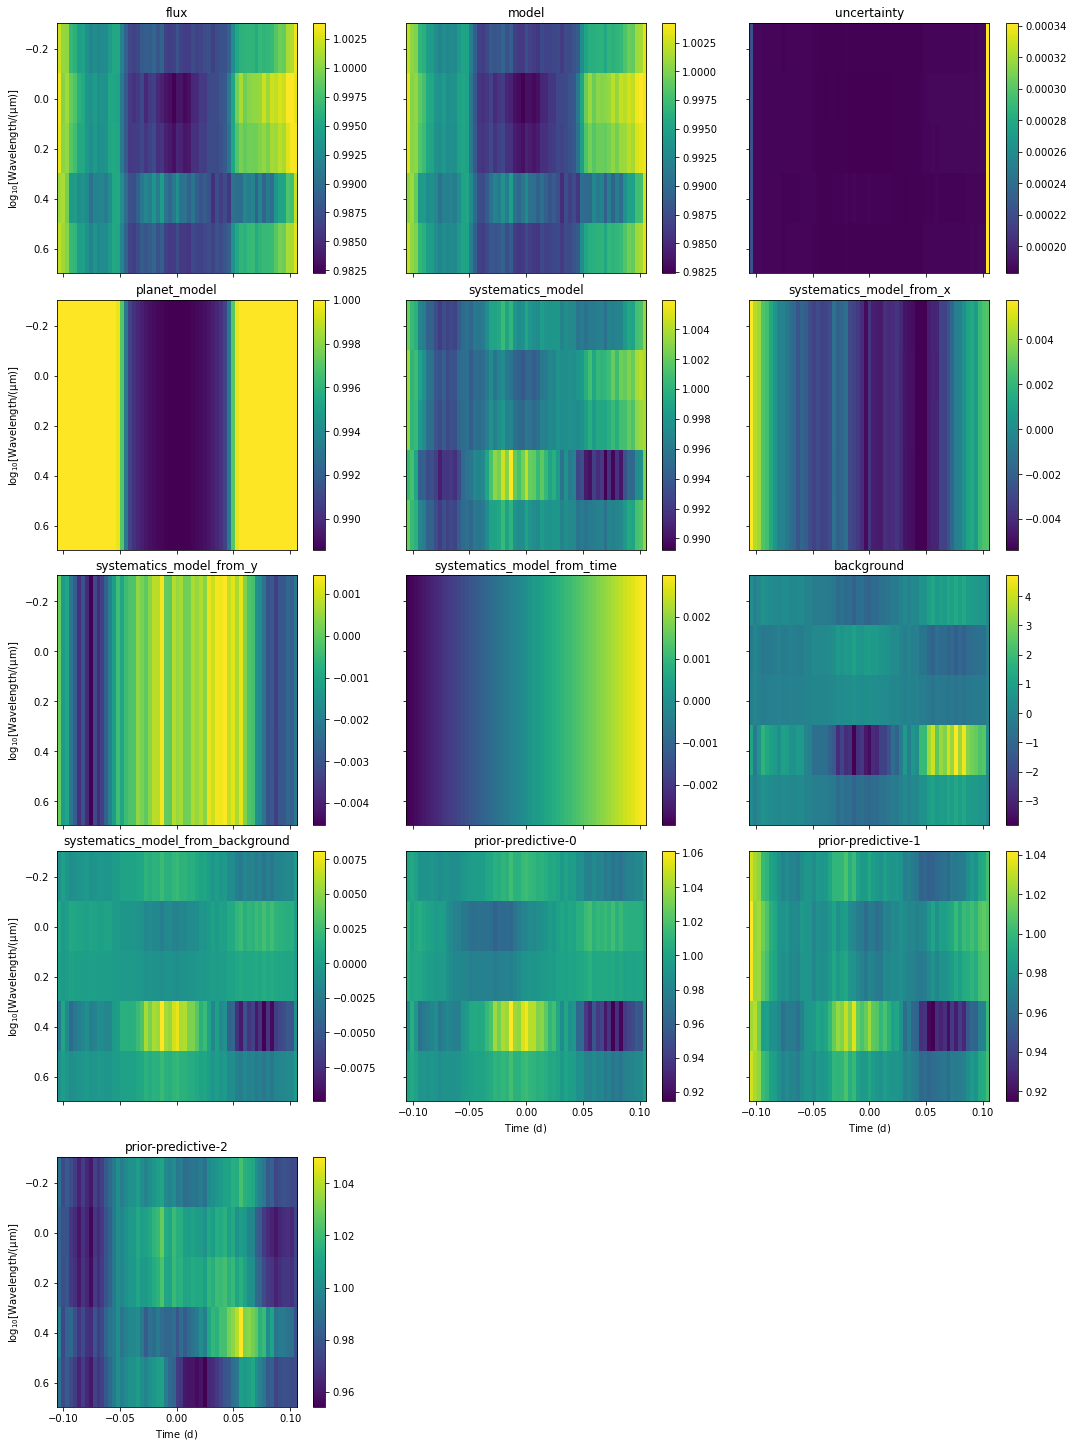

In [55]:
cm.plot_priors()

In [57]:
opt = cm.optimize()
cm.sample(start =opt, tune=4000, draws=4000, cores=4, chains=4)
cm.summarize(round_to=7, fmt='wide')

optimizing logp for variables: [transit_radius_ratio_w4, transit_radius_ratio_w3, transit_radius_ratio_w2, transit_radius_ratio_w1, transit_radius_ratio_w0, transit_limb_darkening, transit_stellar_mass, transit_stellar_radius, transit_impact_parameter, transit_epoch, sbkg_p_1, sy_p_1, sx_p_1, stime_p_1]


message: Desired error not necessarily achieved due to precision loss.
logp: -159992.2023589699 -> 2216.805299410351

🌈 Warning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.Multiprocess sampling (4 chains in 4 jobs)
NUTS: [transit_radius_ratio_w4, transit_radius_ratio_w3, transit_radius_ratio_w2, transit_radius_ratio_w1, transit_radius_ratio_w0, transit_limb_darkening, transit_stellar_mass, transit_stellar_radius, transit_impact_parameter, transit_epoch, sbkg_p_1, sy_p_1, sx_p_1, stime_p_1]


Sampling 4 chains for 4_000 tune and 4_000 draw iterations (16_000 + 16_000 draws total) took 863 seconds.
There were 80 divergences after tuning. Increase `target_accept` or reparameterize.
There were 121 divergences after tuning. Increase `target_accept` or reparameterize.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
There were 700 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.7811096001567097, but should be close to 0.9. Try to increase the number of tuning steps.
The number of effective samples is smaller than 10% for some parameters.


                               mean        sd    hdi_3%   hdi_97%  \
stime_p_1                  0.028702  0.000202  0.028308  0.029061   
sx_p_1                     0.003247  0.000020  0.003212  0.003286   
sy_p_1                     0.002435  0.000015  0.002407  0.002463   
sbkg_p_1                  -0.002106  0.000012 -0.002129 -0.002085   
transit_radius_ratio_w0    0.099883  0.000340  0.099272  0.100545   
transit_radius_ratio_w1    0.100277  0.000342  0.099610  0.100893   
transit_radius_ratio_w2    0.100373  0.000345  0.099721  0.101004   
transit_radius_ratio_w3    0.100490  0.000360  0.099868  0.101202   
transit_radius_ratio_w4    0.100524  0.000342  0.099896  0.101147   
transit_epoch             -0.000016  0.000041 -0.000095  0.000061   
transit_impact_parameter   0.145283  0.064731  0.021197  0.249281   
transit_stellar_radius     1.184517  0.010269  1.166367  1.199993   
transit_stellar_mass       0.833716  0.022391  0.800008  0.873198   
transit_limb_darkening[0]  0.31912


🌈 Warning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample

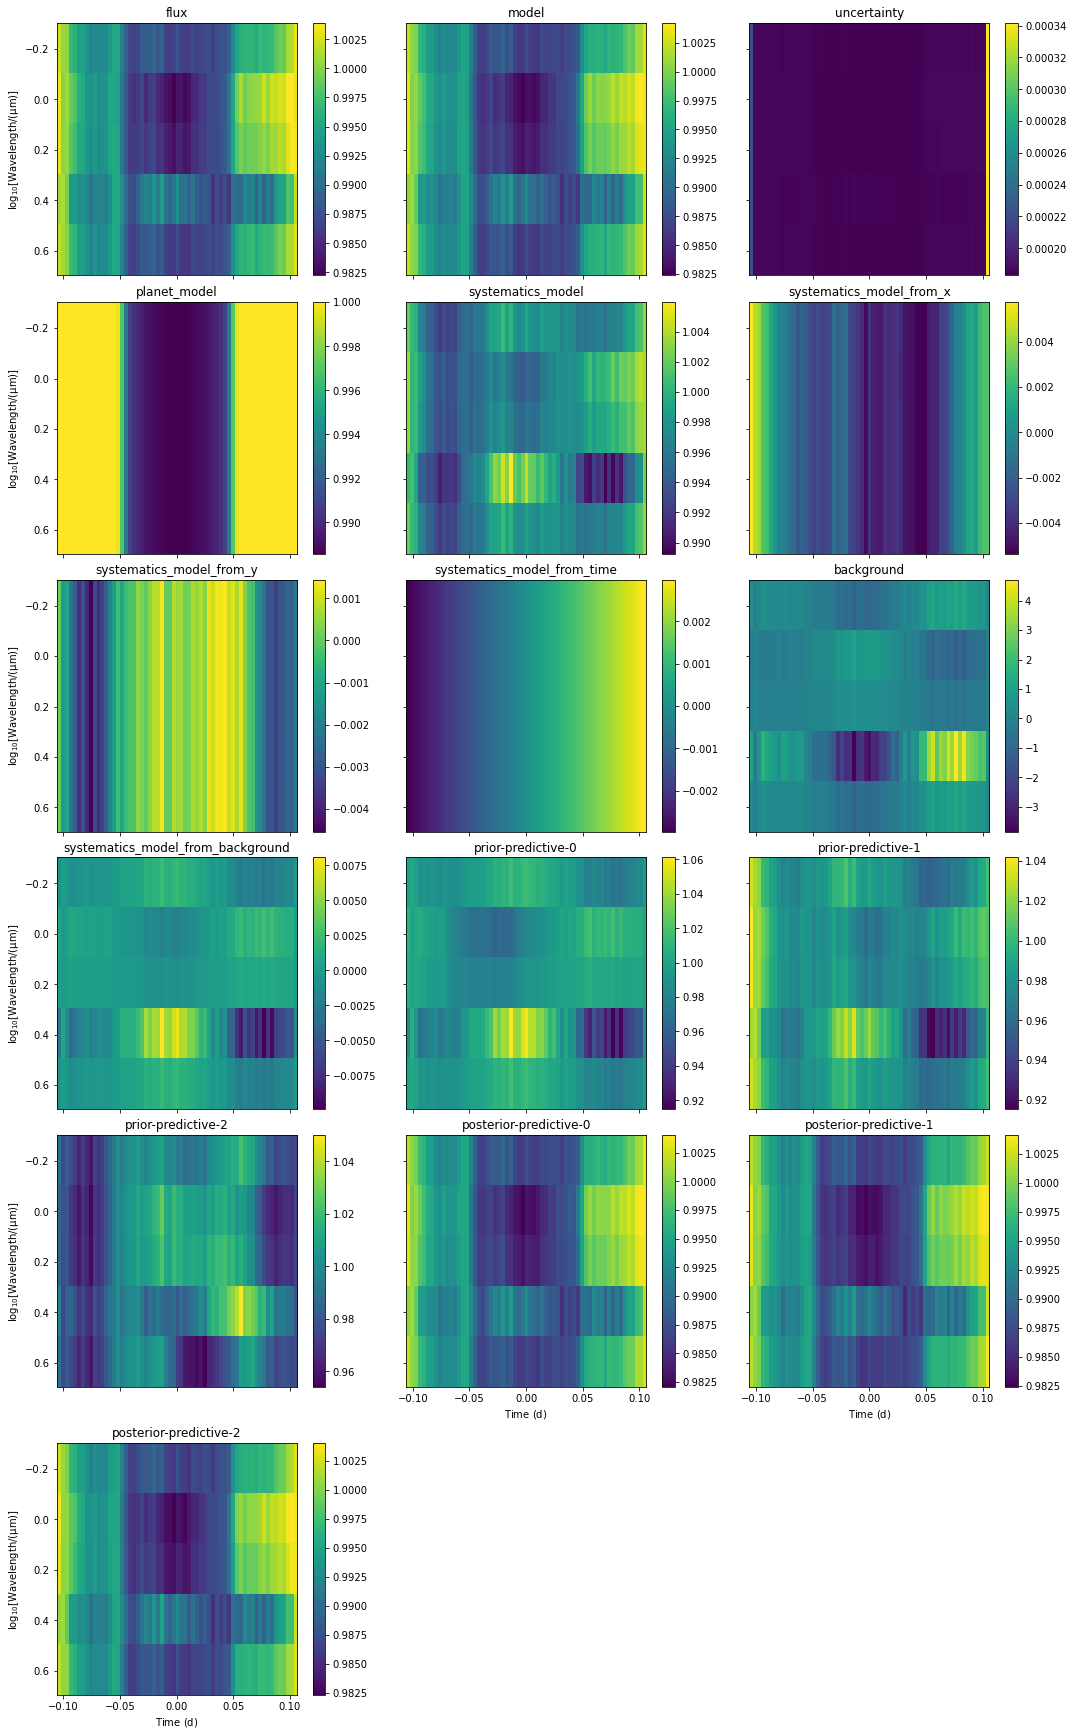

In [58]:
cm.plot_posteriors()

In [59]:
cm.summary['mean']

stime_p_1                    0.028702
sx_p_1                       0.003247
sy_p_1                       0.002435
sbkg_p_1                    -0.002106
transit_radius_ratio_w0      0.099883
transit_radius_ratio_w1      0.100277
transit_radius_ratio_w2      0.100373
transit_radius_ratio_w3      0.100490
transit_radius_ratio_w4      0.100524
transit_epoch               -0.000016
transit_impact_parameter     0.145283
transit_stellar_radius       1.184517
transit_stellar_mass         0.833716
transit_limb_darkening[0]    0.319124
transit_limb_darkening[1]    0.115519
Name: mean, dtype: float64

In [60]:
print(s.metadata['systematics_equation'])
print()
for k, v in s.metadata['systematics_components'].items():
    print(f'{k:>20} = {repr(v)}')

f = 1
  + c_x*(x - offset_x)/sigma_x
  + c_y*(y - offset_y)/sigma_y
  + c_time*(time - offset_time)/sigma_time
  + c_background*(background - offset_background)/sigma_background

            linear_x = 'c_x*(x - offset_x)/sigma_x'
                 c_x = 0.0032417343959125103
            offset_x = 0
             sigma_x = 1
            linear_y = 'c_y*(y - offset_y)/sigma_y'
                 c_y = 0.002414580328515741
            offset_y = 0
             sigma_y = 1
         linear_time = 'c_time*(time - offset_time)/sigma_time'
              c_time = 0.0017333699876688796
         offset_time = <Quantity -0.00069444 d>
          sigma_time = <Quantity 0.06013932 d>
   linear_background = 'c_background*(background - offset_background)/sigma_background'
        c_background = -0.002106743459325645
   offset_background = 0
    sigma_background = 1


In [67]:
cm.data.fluxlike['test_planet_recovered-0'] = cm.data.fluxlike['posterior-predictive-0'] - cm.data.fluxlike['systematics_model']
cm.data.fluxlike['test_residuals-0'] = 1 + cm.data.fluxlike['posterior-predictive-0'] - cm.data.fluxlike['systematics_model'] - cm.data.fluxlike['planet_model']

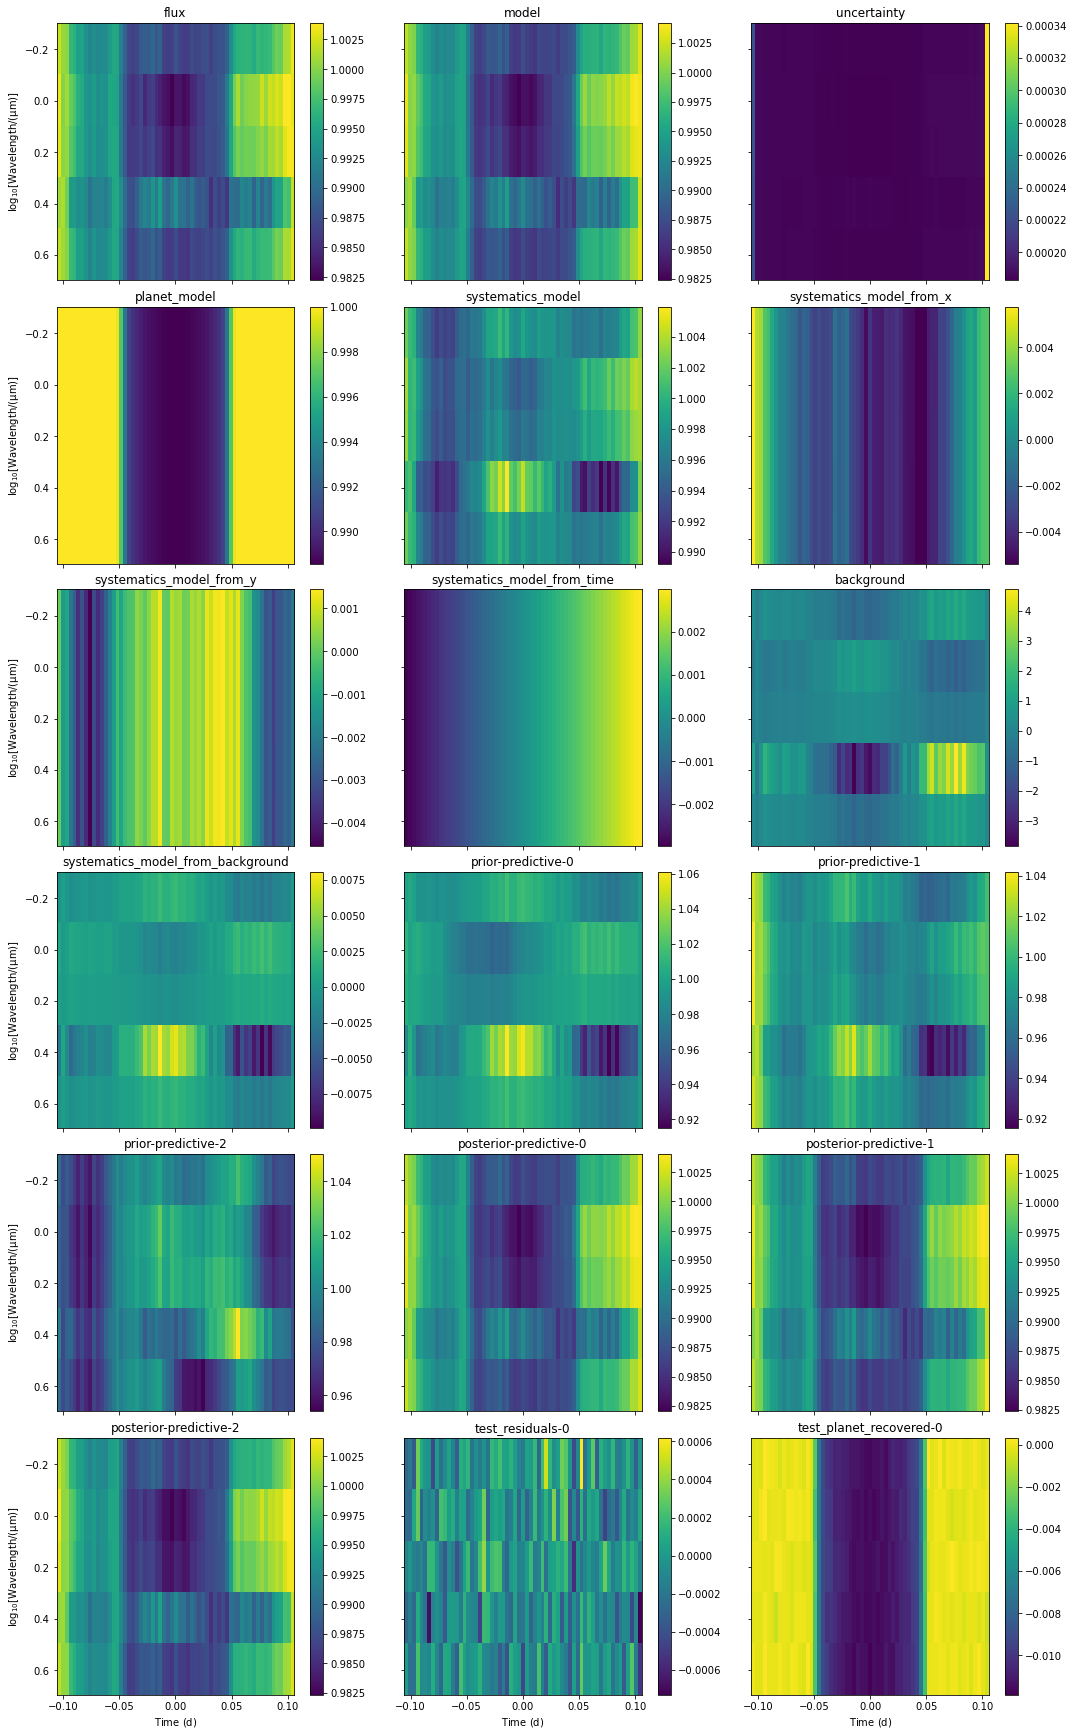

In [68]:
cm.data.imshow_quantities()

# Testing!

optimizing logp for variables: [sbkg_p_1, sy_p_1, sx_p_1, stime_p_1]


message: Optimization terminated successfully.
logp: -52849.34418438209 -> 2223.3164028857623

🌈 Warning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.Multiprocess sampling (4 chains in 12 jobs)
NUTS: [sbkg_p_1, sy_p_1, sx_p_1, stime_p_1]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 4 seconds.



*********
              sx_p_1    sy_p_1  sbkg_p_1  stime_p_1
Injected   0.002051 -0.003559 -0.000538  -0.001925
recovered  0.002052 -0.003584 -0.000533  -0.001886 
*********



optimizing logp for variables: [sbkg_p_1, sy_p_1, sx_p_1, stime_p_1]


message: Optimization terminated successfully.
logp: -52849.34418438209 -> 2223.316402885762



🌈 Warning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.Multiprocess sampling (4 chains in 12 jobs)
NUTS: [sbkg_p_1, sy_p_1, sx_p_1, stime_p_1]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 3 seconds.



*********
              sx_p_1    sy_p_1  sbkg_p_1  stime_p_1
Injected   0.002051 -0.003559 -0.000538  -0.001925
recovered -0.002052  0.003583  0.000533  -0.001892 
*********



optimizing logp for variables: [sbkg_p_1, sy_p_1, sx_p_1, stime_p_1]


message: Optimization terminated successfully.
logp: -56100.03858355301 -> 2201.446194789077



🌈 Warning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.Multiprocess sampling (4 chains in 12 jobs)
NUTS: [sbkg_p_1, sy_p_1, sx_p_1, stime_p_1]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 4 seconds.



*********
              sx_p_1    sy_p_1  sbkg_p_1  stime_p_1
Injected  -0.003154  0.000190  0.004020   0.027577
recovered -0.003148  0.000211  0.004041   0.027611 
*********



optimizing logp for variables: [sbkg_p_1, sy_p_1, sx_p_1, stime_p_1]


message: Optimization terminated successfully.
logp: -56100.03858355301 -> 2201.4461947890773



🌈 Warning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.Multiprocess sampling (4 chains in 12 jobs)
NUTS: [sbkg_p_1, sy_p_1, sx_p_1, stime_p_1]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 4 seconds.



*********
              sx_p_1    sy_p_1  sbkg_p_1  stime_p_1
Injected  -0.003154  0.000190  0.004020   0.027577
recovered  0.003148 -0.000211 -0.004041   0.027609 
*********



optimizing logp for variables: [sbkg_p_1, sy_p_1, sx_p_1, stime_p_1]


message: Optimization terminated successfully.
logp: -36621.243797121584 -> 2222.179626428143



🌈 Warning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.Multiprocess sampling (4 chains in 12 jobs)
NUTS: [sbkg_p_1, sy_p_1, sx_p_1, stime_p_1]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 4 seconds.



*********
              sx_p_1    sy_p_1  sbkg_p_1  stime_p_1
Injected  -0.001144 -0.002010  0.001334   0.011351
recovered -0.001136 -0.002014  0.001333   0.011186 
*********



optimizing logp for variables: [sbkg_p_1, sy_p_1, sx_p_1, stime_p_1]


message: Optimization terminated successfully.
logp: -36621.243797121584 -> 2222.179626428143



🌈 Warning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.Multiprocess sampling (4 chains in 12 jobs)
NUTS: [sbkg_p_1, sy_p_1, sx_p_1, stime_p_1]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 3 seconds.



*********
              sx_p_1    sy_p_1  sbkg_p_1  stime_p_1
Injected  -0.001144 -0.002010  0.001334   0.011351
recovered  0.001136  0.002014 -0.001333   0.011190 
*********



optimizing logp for variables: [sbkg_p_1, sy_p_1, sx_p_1, stime_p_1]


message: Optimization terminated successfully.
logp: -8560.56691610655 -> 2220.88993939168



🌈 Warning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.Multiprocess sampling (4 chains in 12 jobs)
NUTS: [sbkg_p_1, sy_p_1, sx_p_1, stime_p_1]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 4 seconds.

KeyboardInterrupt



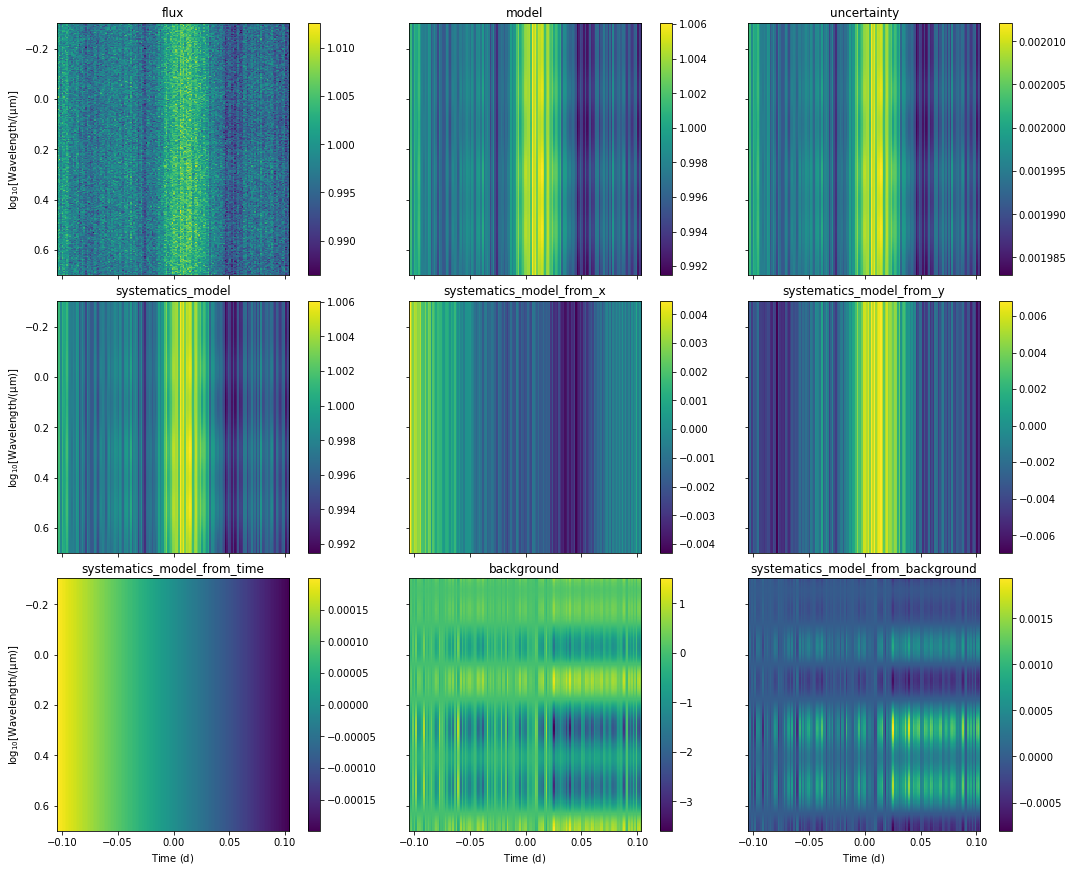

In [ ]:
for i in range(10):
    # create simulated rainbow + noise
    s = SimulatedRainbow().inject_systematics(amplitude=0.002).inject_noise(signal_to_noise=500) #inject_transit().
    s.imshow_quantities();
    s = s.bin(nwavelengths=int(s.nwave/5), dt=5 * u.minute)
    
    cm = b + b_x + b_y + b_bkg
    cm.attach_data(s)
    cm.setup_lightcurves()
    cm.setup_likelihood()
#     print(cm.chromatic_models)
#     print(cm.pymc3_model)
    opt = cm.optimize()
    cm.sample(start=opt, tune=1000, draws=1000, cores=4, chains=4)
    cm.summarize(print_table=False, round_to=7, fmt='wide')
    summary = cm.summary['mean']
    
    meta = s.metadata['systematics_components']
    meta_dict = {'sx_p_1':[meta['c_x']], 'sy_p_1':[meta['c_y']], 'sbkg_p_1': [meta['c_background']], 'stime_p_1': [meta['c_time']/meta['sigma_time'].to_value("day")]}
    
    meta_df = pd.DataFrame(meta_dict,index=['Injected'])
    summary_df = pd.DataFrame(summary).rename({'mean':"recovered"},errors="raise",axis=1).transpose()
    print("\n*********\n", pd.concat([meta_df,summary_df]),"\n*********\n")
    
    cm = b - b_x - b_y - b_bkg
    cm.attach_data(s)
    cm.setup_lightcurves()
    cm.setup_likelihood()
    opt = cm.optimize()
    cm.sample(start=opt, tune=1000, draws=1000, cores=4, chains=4)
    cm.summarize(print_table=False, round_to=7, fmt='wide')
    summary = cm.summary['mean']
    
    meta = s.metadata['systematics_components']
    meta_dict = {'sx_p_1':[meta['c_x']], 'sy_p_1':[meta['c_y']], 'sbkg_p_1': [meta['c_background']], 'stime_p_1': [meta['c_time']/meta['sigma_time'].to_value("day")]}
    
    meta_df = pd.DataFrame(meta_dict,index=['Injected'])
    summary_df = pd.DataFrame(summary).rename({'mean':"recovered"},errors="raise",axis=1).transpose()
    print("\n*********\n", pd.concat([meta_df,summary_df]),"\n*********\n")

In [11]:
a = {'bla':30,'new':2}
b = {'bla':40}

In [12]:
subtract_dicts(a,b)

{'bla': 10, 'new': 2}

In [21]:
c = {**b,**a}
c

{'bla': 30, 'new': 2}

In [22]:
for key, value in c.items():
    if key in a and key in b:
        c[key] = value - b[key]

In [23]:
c

{'bla': -10, 'new': 2}